In [1]:
from simulation_utils import build_data_by_year

# Get data for 2022-2023 season
df = build_data_by_year(2022)

# Get data for the 2023-2024 season
df_2023 = build_data_by_year(2023)

## Setting up Training Data

In [2]:
from simulation_utils import process_fixture_results

# Process the fixture results for the 2022-2023 season and the 2023-2024 season
df, results = process_fixture_results(df)
df_2023, results_2023 = process_fixture_results(df_2023)

results

,Home Outcome,Home Elo,Away Outcome,Away Elo,Total Outcome,Total Elo
Team,,,,,,
Manchester City FC,52,1638.145074,37,1592.172443,89,3230.317517
Arsenal FC,45,1543.120562,39,1528.264097,84,3071.384659
Manchester United FC,48,1575.843091,27,1554.758579,75,3130.601670
Newcastle United FC,39,1556.135005,32,1546.760289,71,3102.895294
Liverpool FC,44,1588.898970,23,1573.569428,67,3162.468398
Brighton & Hove Albion FC,34,1538.182778,28,1517.511950,62,3055.694728
Aston Villa FC,38,1563.241559,23,1548.366690,61,3111.608250
Tottenham Hotspur FC,37,1477.533265,23,1495.146236,60,2972.679501
Brentford FC,37,1560.155453,22,1539.741742,59,3099.897195


### Analyze Elo vs Outcome for Real Results

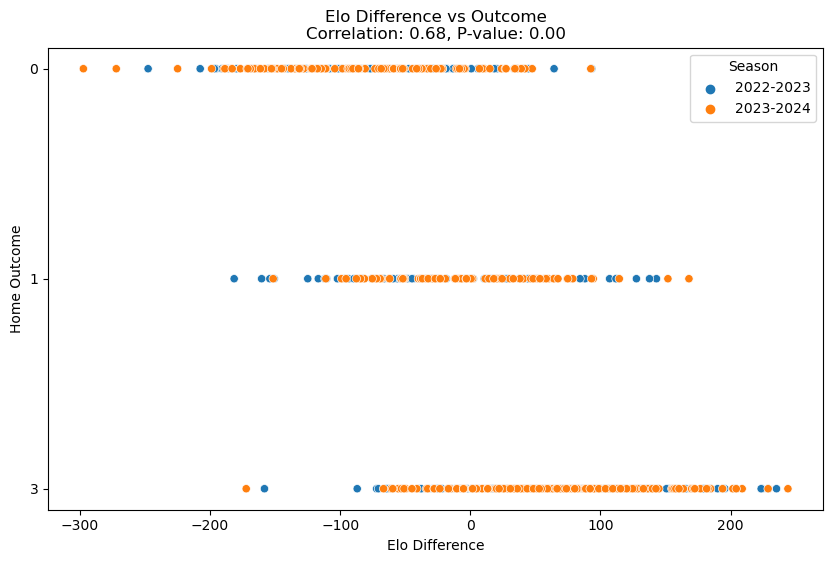

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate Elo vs Outcome correlation
data_2022 = df[["Home Elo", "Away Elo", "Home Outcome"]].copy()
data_2022["Season"] = "2022-2023"
data_2023 = df_2023[["Home Elo", "Away Elo", "Home Outcome"]].copy()
data_2023["Season"] = "2023-2024"
data_2022_2024 = pd.concat([data_2022, data_2023])

data_2022_2024["Elo Difference"] = data_2022_2024["Home Elo"] - data_2022_2024["Away Elo"]

# Convert 'Home Outcome' to categorical type with specified categories
data_2022_2024['Home Outcome'] = pd.Categorical(data_2022_2024['Home Outcome'], categories=[3, 1, 0], ordered=True)

# Calculate correlation
correlation, p_value = pearsonr(data_2022_2024["Elo Difference"], data_2022_2024["Home Outcome"])

# Convert 'Home Outcome' to string type
data_2022_2024['Home Outcome'] = data_2022_2024['Home Outcome'].astype(str)

plt.figure(figsize=(10, 6))

# Visualization
sns.scatterplot(data=data_2022_2024, x="Elo Difference", y="Home Outcome", hue="Season")
plt.title(f"Elo Difference vs Outcome\nCorrelation: {correlation:.2f}, P-value: {p_value:.2f}")
plt.show()

## Training

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For simplicity, let"s predict the home outcome based on Elo ratings
x = df[["Home Elo", "Away Elo"]]
y = df["Home Outcome"]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

# Train the model
model = RandomForestClassifier(n_estimators=1000, max_depth=5, min_samples_split=5)
model.fit(x_train, y_train)

# Validate the model
val_score = model.score(x_val, y_val)
print(f"Validation accuracy: {val_score * 100:.2f}%")

Validation accuracy: 73.68%


### Build Elo

In [5]:
from simulation_utils import build_elo_df_from_dict

# Find teams that have been relegated/promoted by taking a difference of the two dataframes
df_teams = pd.concat([df["Home"], df["Away"]]).unique()
df_2023_teams = pd.concat([df_2023["Home"], df_2023["Away"]]).unique()

relegated_teams = set(df_teams) - set(df_2023_teams)
promoted_teams = set(df_2023_teams) - set(df_teams)
teams_with_baseline = set(df_teams) & set(df_2023_teams)

# Find the average ending ELO rating for the teams that have been relegated
relegated_elo = results.loc[list(relegated_teams), "Total Elo"].max()

# Set the starting ELO rating for the promoted teams to the average ending ELO rating of the relegated teams
elo = {team: relegated_elo for team in promoted_teams}

# Set the starting ELO rating for the teams that have been in the league for both seasons to their ending ELO rating
elo.update(results.loc[list(teams_with_baseline), "Total Elo"].to_dict())

# Divide Elo by 2
elo = {team: elo[team] / 2 for team in elo}

elo_df = build_elo_df_from_dict(elo)
elo_df

,Elo,Club Value,Normalized Club Value,Exponential Club Value,Normalized Exponential Club Value,Adjusted Elo
Team,,,,,,
Manchester City FC,1615.158759,1.320000e+09,1.000000,1.718282,1.000000,1915.158759
Arsenal FC,1535.692329,1.160000e+09,0.867159,1.380140,0.803209,1776.655118
Liverpool FC,1581.234199,9.419000e+08,0.686081,0.985917,0.573781,1753.368422
Manchester United FC,1565.300835,7.186500e+08,0.500726,0.649919,0.378238,1678.772231
Aston Villa FC,1555.804125,6.556000e+08,0.448379,0.565772,0.329266,1654.583945
Newcastle United FC,1551.447647,6.489500e+08,0.442858,0.557151,0.324249,1648.722282
Chelsea FC,1452.783096,9.460000e+08,0.689485,0.992689,0.577722,1626.099605
Tottenham Hotspur FC,1486.339750,7.933000e+08,0.562705,0.755414,0.439634,1618.229830
Brentford FC,1549.948598,4.148800e+08,0.248520,0.282127,0.164191,1599.205923


## Test Against 2023-2024 Season

### Predict 2023-2024 Season

In [6]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

from simulation_utils import simulate_and_get_results

# Get adjusted Elo dict
adjusted_elo = elo_df["Adjusted Elo"].to_dict()

# Number of simulations to run
num_simulations = 100

# Initialize a list to store results
seasons = []

# Initialize a pool of workers
with ProcessPoolExecutor() as executor:
    seasons = list(tqdm(executor.map(simulate_and_get_results, range(num_simulations), [df_2023]*num_simulations, [adjusted_elo]*num_simulations, [model]*num_simulations, [scaler]*num_simulations),  total=num_simulations, desc='Simulating', unit='season'))

Simulating: 100%|██████████| 100/100 [03:41<00:00,  2.21s/season]


### Analyze Results Compared to actual 2023-2024 Season

### Post Process Simulation Results

In [7]:
# Sort results based on total outcome
results = results.sort_values("Total Outcome", ascending=False)

# Get the place each team finished in the league
results["Place"] = range(1, len(results) + 1)

# Get 2023 season results
# Determine outcomes: 3 for win, 1 for draw, 0 for loss
df_2023["Home Outcome"] = 1
df_2023["Away Outcome"] = 1
df_2023.loc[df_2023["Home Score"] > df_2023["Away Score"], "Home Outcome"] = 3
df_2023.loc[df_2023["Home Score"] > df_2023["Away Score"], "Away Outcome"] = 0
df_2023.loc[df_2023["Away Score"] > df_2023["Home Score"], "Away Outcome"] = 3
df_2023.loc[df_2023["Away Score"] > df_2023["Home Score"], "Home Outcome"] = 0

home_results = df_2023.groupby("Home").agg({"Home Outcome": "sum"})
away_results = df_2023.groupby("Away").agg({"Away Outcome": "sum"})
results_2023 = home_results.join(away_results, how="outer").fillna(0)
results_2023["Total Outcome"] = results_2023["Home Outcome"] + results_2023["Away Outcome"]
results_2023 = results_2023.sort_values("Total Outcome", ascending=False)
results_2023["Place"] = range(1, len(results_2023) + 1)

# For each season, get the place each team finished in the league
for index, season_df in enumerate(seasons):
    season_df["Place"] = range(1, len(season_df) + 1)

# Get the average place each team finished in the league
average_results = pd.concat(seasons).groupby("Team").agg({"Place": "mean"}).sort_values("Place")

# Get a mapping of team names to a list places they finished in the league
team_place_mapping = {}
for team in average_results.index:
    team_place_mapping[team] = [season_df.loc[team, "Place"] for season_df in seasons]

# Get the total number of seasons simulated
total_seasons = len(seasons)

# Get a mapping of times each team won the league
team_win_mapping = {}
for team in average_results.index:
    team_win_mapping[team] = sum([season_df.loc[team, "Place"] == 1 for season_df in seasons]) / total_seasons

# Get a mapping of times each team finished in the top 4
team_top_4_mapping = {}
for team in average_results.index:
    team_top_4_mapping[team] = sum([season_df.loc[team, "Place"] <= 4 for season_df in seasons]) / total_seasons

# Get a mapping of times each team finished in the bottom 3
team_bottom_3_mapping = {}
for team in average_results.index:
    team_bottom_3_mapping[team] = sum([season_df.loc[team, "Place"] >= len(season_df) - 3 for season_df in seasons]) / total_seasons

# Build a dataframe with the average place, times won, times in top 4, and times in bottom 3
average_results["Win Premier League"] = [team_win_mapping[team] for team in average_results.index]
average_results["Top 4"] = [team_top_4_mapping[team] for team in average_results.index]
average_results["Bottom 3"] = [team_bottom_3_mapping[team] for team in average_results.index]

# Show the dataframe
average_results

,Place,Win Premier League,Top 4,Bottom 3
Team,,,,
Manchester City FC,4.12,0.15,0.62,0.00
Arsenal FC,5.10,0.11,0.47,0.00
Liverpool FC,5.27,0.07,0.48,0.00
Aston Villa FC,5.51,0.16,0.40,0.00
Manchester United FC,5.65,0.14,0.40,0.00
Newcastle United FC,5.67,0.10,0.38,0.00
Chelsea FC,5.72,0.10,0.38,0.00
Tottenham Hotspur FC,6.63,0.04,0.27,0.00
Brighton & Hove Albion FC,7.69,0.05,0.24,0.00
